The notebook should be seen in combination with the [website](https://christian-kento-rasmussen.github.io/US-Congress-Twitter-Behavior) and [github](https://github.com/christian-kento-rasmussen/US-Congress-Twitter-Behavior).

# Explainer-Notebook

## Main contributions

We all worked together on everything in the notebook, but each member had main responsibilities. Therefore, some parts were mainly coded by a single team member, but everything was discussed and analyzed by the whole group.

Benjamin (s21549):

Website:
* Introduction
* Data description
* 2nd Part of network structure
* 2nd part of community ("Analysis of the communities splits") + helped writing first part

In the notebook:

* What is the data?
* Choices in preprocessing

(Tools theory and analysis):
* Data collection
* Communities until and including Seaborn plot
* Data processing

(Discussion):
* Community detection
* Semantic analysis of edges
* Demographics



Mathias (s201968): 

Website:
* Network: Parts of statistical analysis
* Communities: First part of the community section (until analysis of communities splits)
* Text: Analysis of last community and conclusion
* Evolution: Conclusion

Notebook:
* Section 1: End user experience
* Section 3: Community after Seaborn (Louvain communities confusion matrices, netwulf graphs, summary statistics of communities)
* Section 3: Parts of text analysis
* Section 4: Parts of improvement on text analysis
* Section 4: What went well?
* Section 4: Conclusion



Christian (s204159):

Website:
* Introduction
* Data description (Graph part)
* Network: First part with statistical test and assortativity
* Text: Everything
* Evolution: Everything

Explainer notebook:
* Basic data statistics
* Tools used for Mixing Patterns and Assortativity
* Tools used in the Tweet Analysis section
* Temporal Analysis
* Conclusion



# Section 1: Creation of dataframes and graph

### Motivation
In this report, we want to explore how the US Congress communicates on twitter.

It seems like there is a lot of talk in the news about polarization in US politics between democrats and republicans. We would like to explore whether this polarization exists in reality, that is, do democrats and republicans actually never cooperate, or this just an image potrayed by the media? As a proxy measurement for this, we’ve decided to look at twitter exchanges between members of the U.S congress and organization related to these in order to look for patterns that may tell us, how the U.S congress communciates. Our data consists of tweets made by members of congress, governmental organization and caucuses from 2017-2023 including data such as political affiliation and region of the different political users.

### Goals for end user experience
We wanted to make a website with two functionalities. First and foremost, we wanted the user to be able to understand the visualizations and main points of the analysis without a technical background. This meant putting every visualization in perspective during the analysis, and following every analysis up with a conclusion on what the findings could indicate. It also put strict requirements on the fidelity of the visualizations, which we strive to make as accesible as possible.
Secondly, we wanted the user with a technical background to be able to dive deep into the details of the analysis and make their own conclusions. This meant clearly stating the procedure and including visualizations of subresults and not just the final product. In some ways, this could conflict with our first functionality, but we attempt to fit the needs of both types of users, such that our analysis and message is not either restricted to just those with a technical background, or so superficial that it would not be interesting to those with a technical background.

### The notebook and website is structured in the following way.
The notebook should be seen in combination with the [website](https://christian-kento-rasmussen.github.io/US-Congress-Twitter-Behavior) and [github](https://github.com/christian-kento-rasmussen/US-Congress-Twitter-Behavior). The website's homepage contains a longer motivation behind our report and which topics we have covered. It also holds detailed analysis of each graph generated from the below code.


The notebook is structure in the following way

1. In section 1, we cover dataprocessing and creation of the dataframes and graphs.
2. In section 2, we cover the basic structure of our dataset (each dataframe and the graph).
3. In section 3, we cover the different analysis tools we have used for each page on the website.
4. In section 4, we discuss what went well and what could be improved

### What is the data?

### Raw data

The raw data consists of a range of tweets made by users all related to the U.S congress  either as members, committees or caucus, with the tweets' IDs, the user's handle names, timestamp, a link to the tweet and finally the text of the tweet.  The tweets were taken daily from 2017-2023 and were arranged in JSON files by date with a time resolution of months. A compressed and preprocessed version of the data can be found [here](https://drive.google.com/file/d/1U97402z94nU_wI4EEATKgudUkeItZuPj/view?usp=sharing)

We also had a JSON file called "historical users" consisting of data on the different twitter users. It contained the name of the user, which chamber they were a part of, their political affiliation, what type of user they were (comittee, political party, member or caucus) and a list of which twitter accounts were associated with that user. Furthermore, if the user was a member of congress they would also have a field explaining which state they represented. 

10 of the members had a prev_props field, which indicated which political party, if not their own, they had served and when.

The accounts list consisted of dictionaries with the handle names, what the accounts had been used for (campaign, office etc.) and unique IDs of the different twitter accounts belonging to that person. Some of the twitter accounts also had old handle names, which were included in the accoutns list.

## Data frames

In the following section we will explain how each of the 4 dataframes are build; User, accounts, tweets and text dataframe.

**User dataframe** 
A dataframe of the bibliographic data surrounding a single twitter user, a user being the organization or persons(s) actually using twitter.

Size: 806 entries; With parameters
- name: This was the unique identifier of each user as no user had the same exact name.
- chamber: Which chamber (if any,) the user was a part of, could either be house or congress.
- type: Whether they were a (congress) member, caucus, party or committee
- party: Which political party they were party of
- id: Their ID
- state: Which state they represented, if they were a member of a congress
- prev_props: 10 users had served under different parties previously, prev_props told us which parties and the timeframe.

In [80]:
# imports
import json
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
from scipy import stats
from collections import defaultdict
from scipy.optimize import curve_fit
import netwulf as nw
import seaborn as sns
import pickle
from nltk.corpus import stopwords
from ast import literal_eval
import nltk
from tqdm import tqdm
import re

In [4]:
filteredDataFilePath = "../local/congresstweets-master/data"
users_DF = pd.read_json(filteredDataFilePath)

#Check for duplicate names
names_list = users_DF["name"]
duplicate_names_counter = 0
for name in names_list:
    name_query = users_DF[users_DF["name"] == names_list[0]]
    if(len(name_query)>1):
        print(name_query)
        duplicate_names_counter += 1

if(duplicate_names_counter>0):
    print(f"Number of duplicate names: {duplicate_names_counter}")
else:
    print("We can use name as a unique identifier for Twitter users")

**Accounts dataframe** :

Each user could have multiple accounts. The accounts dataframe was therefore a way to link twitter accounts' handles and ids to the user behind them. 

- screen_name: The username of that account
- account_type: What the account was used for, i.e. campaign, office etc.
- name: The name of the user behind the account

In [ ]:
"""
We create a seperate dataFrame for quickly connecting twitter handles with names.
We need this in order to iterate over the tweets and filter mentions based on whether they're part of our filtered dataset.
"""

#Get all the account dicts as rows
accounts_dataFrame = users_DF[["accounts"]].explode(["accounts"])["accounts"].apply(pd.Series)
users_DF = users_DF.drop("accounts",1)

accounts_dataFrame["name"] = users_DF["name"]
accounts_dataFrame = accounts_dataFrame.drop(["party","type","deleted","chamber"],1)

#As can be seen some of the twitter accounts have had previous names, which we further need to explode and add to the dataframe
#We swap screen_names with prev_names, and add the new connections between names and twitter handles to the original accounts_DF

prev_names_DF = accounts_dataFrame[accounts_dataFrame["prev_names"].isna() == False].explode("prev_names").drop("screen_name",1)

prev_names_DF.columns = ["id","account_type","screen_name","name"]
accounts_dataFrame = pd.concat([accounts_dataFrame,prev_names_DF]).drop("prev_names",1)

**Tweets dataframe** :

The tweets dataframe stores information surrounding a tweet. This made it easy for us to create a graph later on, as all the edges could be found in the tweets dataframe. Each entry is a single tweet.

Size: 4777249 entries

- user_name: The username of the user behind the tweet

- screen_name: The name of the account from which the tweet was posted

- tweet_account_ID: The ID of that account

- tweet_ID: The unique identifier identifying that single tweet

- handles_mentioned: All the twitter handles mentioned, which are in our account dataframe.

- names_mentioned: The username of the accounts mentioned.

**Text dataframe:**

The text dataframe consists of all the text of every tweet in the tweets dataframe. The primary purpose of this dataframe was to provide an organized way to do text analysis.

Each row is a single tweet.

Size: 4777249 entries

- user_name: The username of the user behind the tweet

- screen_name: The name of the account from which the tweet was posted

- text: The actual text of that tweet

- tweet_ID: The unique identifier identifying that single tweet

In [ ]:
RT_pattern = "RT @[a-zA-Z0-9]*"

def searchText(formula,twitter_message):
    try:
        matches = re.findall(formula,twitter_message)
        matches[0]
        return matches
    except:
        return None

#Takes a tweet and returns a list of mentions - bar RT mentions - that are in our accounts_dataFrame and their corresponding users' names
def get_Handles_Names(tweet):
    mentions_re = "@[a-zA-Z0-9]*"
    mentions_excl_RT_re = "(?<!RT )@[a-zA-Z0-9]*" #Will exclude all mentions that follow "RT"
    mentions = searchText(mentions_re,tweet)
    screen_names = []
    names_result = []

    #If there is a mention
    if(mentions != None):
        mentions = [handle[1:] for handle in mentions] #Remove @

        #Add to our dict, if the mentions exist in our dataFrame
        for idx,handle in enumerate(mentions):
            names = accounts_dataFrame[accounts_dataFrame['screen_name'] == handle]['name']

            #If the handle exists in our filtered accounts_dataFrame
            if(len(names)>0):
                screen_names += [handle]
                names_result += list(names)
    if(len(names_result)>0):
        return screen_names,names_result
    else:
        return None,None

def get_tweeter_screen_name(tweet):
    return tweet["screen_name"]



#In case the way we accept tweets changes
def accept_tweet(tweet):
    screen_name = [get_tweeter_screen_name(tweet)]

    #We check to see if the sender is a part of our network
    if(accounts_dataFrame["screen_name"].isin(screen_name).sum() == 1):
        return True
    else:
        return False


def get_tweets_row(tweet,year):
        screen_name = get_tweeter_screen_name(tweet)
        tweet_text = tweet["text"]
        tweet_ID = tweet["id"]
        tweet_account_ID = tweet["user_id"] #What they call user, we call account

        handles_mentioned,names_mentioned = get_Handles_Names(tweet_text)
        hashtags = searchText(hashtags_re,tweet_text)
        user_name = list(accounts_dataFrame[accounts_dataFrame["screen_name"] == screen_name]["name"])[0]

        return {"user_name":user_name,"screen_name":screen_name,"tweet_account_ID":tweet_account_ID,"tweet_ID":tweet_ID,"handles_mentioned":handles_mentioned,"names_mentioned":names_mentioned,"hashtags":hashtags,"year":year}

def get_text_row(tweet):
        screen_name = get_tweeter_screen_name(tweet)
        user_name = list(accounts_dataFrame[accounts_dataFrame["screen_name"] == screen_name]["name"])[0]
        tweet_text = tweet["text"]
        tweet_ID = tweet["id"]
        return {"user_name":user_name,"screen_name":screen_name,"text":tweet_text,"tweet_ID":tweet_ID}


We will now create the Tweets and text dataframes

In [ ]:
tweets_DF = pd.DataFrame(["user_name","screen_name","tweet_account_ID","tweet_ID","handles_mentioned","names_mentioned","hashtags"])

hashtags_re = "#[a-zA-Z0-9]*"

#Regex assumes \ is an escape char, Python assumes \\ is an escape char for a single \, we need \\ (Regex) -> \\\\ (Python)
year_re = "\\\\[0-9]*-"
tweets_rows = []
text_rows = []
false_tweets = 0
total_tweets = 0

for idx,filename in enumerate(os.listdir(dataFilePath)):
    print(idx)

    full_path = os.path.join(dataFilePath, filename)
    tweet_year = re.search(year_re,full_path)[0][1:-1]

    with open(full_path, encoding="utf8") as f:
        json_file = json.load(f)

    try:
        for tweet in json_file:
            if(accept_tweet(tweet)):
                tweets_rows += [get_tweets_row(tweet,tweet_year)]
                text_rows += [get_text_row(tweet)]
                total_tweets += 1

    except Exception as e:
        false_tweets += 1
        print(tweet)
        print(e)

#We now have our four different dataFrames.
tweets_DF = pd.DataFrame.from_dict(tweets_rows,orient="columns")
text_DF = pd.DataFrame.from_dict(text_rows,orient="columns")

# Section 2: Basic stats. Let’s understand the dataset better

## Write about your choices in data cleaning and preprocessing

We made multiple choices when extracting and processing the data from our raw JSON file, as described above.

User dataframe:

- Removing prev_pres: As mentioned, there was an attribute called "prev_pres," which, if the member had been elected for a previous party or house, described this party or house. However, only 10 members in total had this attribute, so we decided to consider it as an outlying attribute and removed it from our graph. 

Tweets dataframe:

-  Multiple mentions in the same tweet: One could argue, that multiple mentions in the same tweet should account for a single edge, as it could be viewed as a single instance of communication. However, at the same time, one most likely does not accidentally mention another twitter user, and there is therefore en explicit attempt at connection between the mentioner and the mentioned. As we're researching how the different congress members relate to one another, it would not make sense to throw away this information, despite the fact, that it may cause overrepresentation of certain individuals who're connected with other individuals that use a lot of mentions in their tweets compared to the average.

- Only including mentions to accounts in our accounts dataframe: We did not include mentions directed at- or from accounts outside our accounts dataframe, as we would have no political information on these accounts, the most important being which party they belonged to. It would therefore most likely not make sense to include these extra edges and nodes, as it would just unnecessarily increase the complexity of our graph, and not help us answer our main research question regarding whether or not the U.S Congress is politically polarized.

- Include RT tweets: We included retweets as we saw them as a piece of information regarding the relationship between two users. 

Graph:


- Directed: The choice of using a directed graph versus an undirected graph stems from the fact, that there is a huge difference between a user who mentions a lot of other users, or whom is mentioned by a lot of other users. With the ladder playing a more central role in our network.

- Multigraph: We couldn't just assign number of tweets between two nodes as weights, as we needed to separate the graph by year later on, and we would therefore have to mark which how many mentions were distributed in each year. Also, originally we had intended to use semantic analysis, and by using the multigraph, we could have a single weight for semantics. This would make it much easier to use the standard tools we had, like Netwulf and NetworkX.

- Users are nodes, not accounts: For the choice of using twitter users instead of their accounts as the nodes of our graph, we went with the twitter users. Having the accounts as nodes would've added more detail, as there could now be cases where the same users had accounts in different communities. Or, we could see how the different election periods affected the use of different accounts. However, it would also add much more complexity to our graph, and it could have had a possibility of making it much harder to get an overview of our network based off of visual cues, like our Netwulf graph. As we had limited time for this assignment, we therefore went with the former option.

## Main Graph creation

In the following section we will create the main graph

In [ ]:
#When we load the dataFrame, it interprets the names_mentioned as a string, not a list
def read_names_mentioned(tweet):
    return literal_eval(tweet["names_mentioned"])

def load_DF(path):
    return pd.read_csv(path).drop("Unnamed: 0",1)

#And load the different dataFrames
tweets_DF = load_DF("tweetsDF")
text_DF = load_DF("textDF")
users_DF = load_DF("userDF")
accounts_dataFrame = load_DF("accountsDF")

After having created our different dataframes, we now reached the last data extraction state.

We wanted to model the relationship between the different of the US congress, not their twitter accounts, so each node in our graph consists of a single user and its data from the user dataframe.

In order to construct the actual graph, we started by constructing the edges by looking at each tweet from our tweets dataframe that mentioned at least one other user from the account dataframe. We then created an edge between the user who tweeted the tweet and each mention in that tweet. If the same user was mentioned multiple times, there would be created an edge for every mention.

As we wanted to do text analysis on the communities of the graph and a temporal analysis later on, we added the year of the tweet as well as the tweet's ID to every edge. This way we could look at all the edges of each community and get the text from those tweets from the text dataframe, and we could separate the different edges into different graphs by year.

In [ ]:
tweets_w_edges = tweets_DF[tweets_DF["names_mentioned"].isna() == False]

edges = []
for idx in range(len(tweets_w_edges)):
    tweet = tweets_w_edges.iloc[idx]
    origin = tweet["user_name"]
    name_mentions = read_names_mentioned(tweet)
    try:
        for name_mention in name_mentions:
            if (origin != name_mention):
                edges += [(origin, name_mention,{"year":tweet["year"],"ID":tweet["tweet_ID"]})]
                if (len(name_mention) == 1):
                    print(f"Origin:{origin} and the mentioned: {name_mention}")
    except:
        print(tweet)

We then created a directed multigraph based on the edges. 

The next step was adding the attributes of each node:

In [ ]:
#Now we add our attributes to the nodes in the graph
attribute_dicts = dict()

#For each node, we create an attributes dict
for idx in range(len(users_DF)):
    row = users_DF.iloc[idx]
    node_dict = dict()

    #We take all the attributes but name and id
    for attr in users_DF.drop(["name","id"],1).columns:
        value = row[attr]
        node_dict[attr] = value

    attribute_dicts[row["name"]] = node_dict

nx.set_node_attributes(G,attribute_dicts)
print(f"A quick litmus test: {G.nodes['Bernie Sanders']}\nThe values should be equal to senate, member, I, VT and nan")

Finally, we created a directed multigraph for every year we had tweets. 

For year i, if a node had edges from- or to itself with the attribute year = i, the two nodes and the edge was included in the graph for that year.

In [ ]:
#Finally we create a graph for every year there is a tweet
years = nx.get_edge_attributes(G, "year")  # Get the year attribute for each edge
graph_by_year = {}  # Dictionary to store subgraphs by year


for edge in G.edges(data=True):
    year = edge[2]["year"]

    # Create a new subgraph for each year
    if year not in graph_by_year:
        graph_by_year[year] = []

    graph_by_year[year] += [edge]# Add the edge to the respective subgraph


In [ ]:
#We now need to populate the nodes' attributes

#We were not succesful in extracting a subgraph based on the edges directly,
#or using the nx.set_node(), so we're just gonna iterate over all the nodes and set their attributes "manually"
all_node_attributes = {"chamber":None,"type":None,"party":None,"state":None,"prev_props":None}

for idx,year in enumerate(graph_by_year.keys()):

    yearGraph = nx.MultiDiGraph(graph_by_year[year])

    #First we populate our "all_node_attributes"
    for attr in all_node_attributes.keys():
        all_node_attributes[attr] = nx.get_node_attributes(G,attr)

    #We then iterate over all the attributes and set them in our graph
    for node_attr in all_node_attributes.keys():

        #single node attribute, like chamber,type, etc.
        single_node_attribute = all_node_attributes[node_attr]


        for node in single_node_attribute.keys():
            if(node in yearGraph.nodes):
                yearGraph.nodes[node][node_attr] = single_node_attribute[node]

    pickle.dump(yearGraph, open(f'directed_multi_twitter_graph_fixed{year}.pickle', 'wb'))

## Basic data statistics

We start by getting the basic statistics of the graph. It has 803 nodes and 1602970 edges. With a median degree of 2325

In [7]:
G = pickle.load(open('../local/directed_Multi_twitter_graph.pickle', 'rb'))
print(G)

degree_list = list(G.degree())
degree_list = [degree_tuple[1] for degree_tuple in degree_list]
print(f"average {np.mean(degree_list)}, \nmedian {np.median(degree_list)}, \nmode {stats.mode(degree_list)[0][0]}, \nminimum {np.min(degree_list)}, \nmaximum {np.max(degree_list)} \nvalue of the degree\n\n")

MultiDiGraph with 803 nodes and 1602970 edges
average 3992.453300124533, 
median 2325.0, 
mode 313, 
minimum 1, 
maximum 86915 
value of the degree




When looking at the degree distribution graph below we can see that the distribution of degree of edges is very skewed. This means that there are a few nodes with a very high degree and a lot of nodes with a very low degree. This is expected as there are a few users who are very active on twitter and a lot of users who are not. When plotting the distribution on a log-log scale we can see that the distribution looks to loosely follow a power law.

In degree: average 1996.2, 	median 1176.0, 	minimum 0, 	maximum 45833 
Out degree: average 1996.2, 	median 1019.0, 	minimum 0, 	maximum 46102


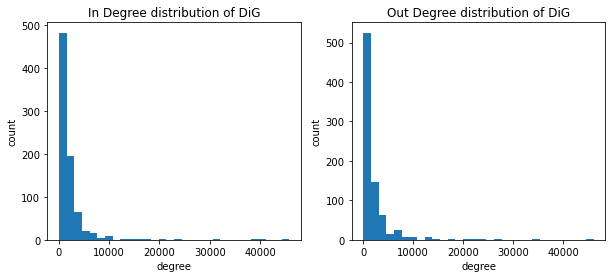

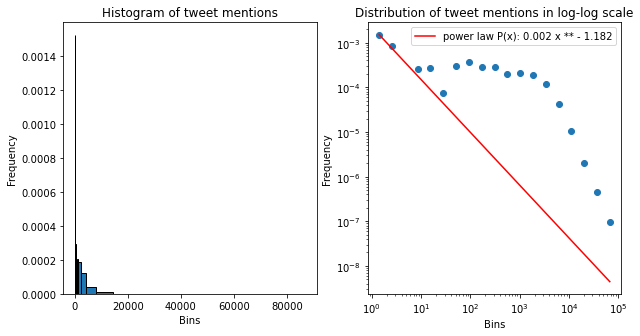

In [10]:
in_degrees = [degree for note, degree in G.in_degree()]
out_degrees = [degree for note, degree in G.out_degree()]
print(f"In degree: average {np.mean(in_degrees):0.1f}, \tmedian {np.median(in_degrees)}, \tminimum {np.min(in_degrees)}, \tmaximum {np.max(in_degrees)} ")
print(f"Out degree: average {np.mean(out_degrees):0.1f}, \tmedian {np.median(out_degrees)}, \tminimum {np.min(out_degrees)}, \tmaximum {np.max(out_degrees)}")

fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].hist(in_degrees,bins=30)
ax[0].set_title('In Degree distribution of DiG')
ax[0].set_ylabel('count')
ax[0].set_xlabel('degree')

ax[1].hist(out_degrees,bins=30)
ax[1].set_title('Out Degree distribution of DiG')
ax[1].set_ylabel('count')
ax[1].set_xlabel('degree')

plt.show()

def power_law_plots(data, name):
    '''
    data: the data to use
    name: the name of the variable in interest
    '''
    # Define the bin edges using a logarithmic scale
    logbins = np.logspace(np.log10(np.min(data)), np.log10(np.max(data)), 20)

    # Create the histogram
    hist, bins = np.histogram(data, bins=logbins, density=True)

    # Compute the bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2

    def power_law(x, C, gamma):
        return C * x**(-gamma)

    popt, pcov = curve_fit(power_law, bin_centers, hist, maxfev=10000)

    # Create a figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the histogram on the first subplot
    ax[0].bar(bins[:-1], hist, width=np.diff(bins), align='edge', edgecolor='black')
    ax[0].set_xlabel('Bins')
    ax[0].set_ylabel('Frequency')
    ax[1].set_yscale('log')
    ax[0].set_title(f'Histogram of {name}')

    # Plot the line on the second subplot
    ax[1].scatter(bin_centers, hist)
    ax[1].plot(bin_centers, power_law(bin_centers, *popt), 'r-', label='power law P(x): %5.3f x ** - %5.3f' % tuple(popt))
    ax[1].set_xlabel('Bins')
    ax[1].set_ylabel('Frequency')
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_title(f'Distribution of {name} in log-log scale')
    ax[1].legend()

    plt.show()

power_law_plots([mentions for node, mentions in G.degree(weight='weight')], 'tweet mentions')

We then wanted to look at the users with the highest in and out degree

In [11]:
in_degrees_sorted = [(node, degree) for node, degree in G.in_degree()]
in_degrees_sorted.sort(key=lambda x: x[1], reverse=True)
out_degrees_sorted = [(node, degree) for node, degree in G.out_degree()]
out_degrees_sorted.sort(key=lambda x: x[1], reverse=True)


print("in degrees sorted : \n", in_degrees_sorted[:5])
print("out degrees sorted : \n", out_degrees_sorted[:5])

in degrees sorted : 
 [('House Committee on the Judiciary', 45833), ('House Republicans', 40813), ('House Democrats', 39010), ('Nancy Pelosi', 31199), ('Kamala Harris', 23417)]
out degrees sorted : 
 [('House Republicans', 46102), ('Senate Democrats', 35122), ('Hispanic Caucus', 34523), ('Senate Republicans', 27451), ('House Democrats', 23871)]


From this we can see that the most mentioned twitter account for all years are for 'VP' and 'SpeakerPelosi'. This comes as no suprise beause they are some of the main twitter accounts for the united states goverment and they have been activate for all years we have data for.

For the out degree we have 'RepDonBeyer', 'RepDonBacon and 'auctnr1' which is the account for 'Billy Long'. They are all very activate republian twitter users. That averages multiple tweets each day. 'NRCC' is another interesting account, beacuse it is not a person but a group as stated on the twitter bio: "The NRCC is dedicated to defending our conservative majority in the House". 

# Section 3: Tools, theory and analysis. Describe the process of theory to insight

* Talk about how youve worked with text, including regular expressions, unicode, etc.
* Describe which network science tools and data analysis strategies youve used, how those network science measures work, and why the tools youve chosen are right for the problem youre solving.
* How did you use the tools to understand your dataset?

## Communities

We used NetworkX's modularity function to measure the quality of our network partitions. It measures this by looking at the edges intra-community with edges going outside the community and comparing it with our modulation and a random graph. The higher the modularity, the more non-random our communities are, and therefore we assume them to be better defined. That is, if we could achieve the modulation from pure chance, it most likely is not a community. 

One of the qualitative tools we used was the Netwulf graph visualization tool. It works by applying physics to the edges and nodes, such that we get a more dynamic graph, which pushes away nodes from each other and makes it easier to distinguish them from one another. 

In conjunction with the modularity, Netwulf allowed us to recognize, that partitioning the network into party-chamber configurations was a better partition than simply by party-party. Modularity then allowed us to confirm this hypothesis qualitatively.

In [13]:
G = pickle.load(open('../local/directed_Multi_twitter_graph.pickle', 'rb'))

def replace_na(graph,code_for_NaN = ''):
    #We turn NaNs into '' - this is only for Netwulf, as JSON cannot handle Nan values
    for node_key in graph.nodes:
        node = graph.nodes[node_key]
        for attribute in node.keys():
            if(type(node[attribute]) == float):

                #If !(x>=0 or x<=0) => x is not a float, x is a nan value
                if not(node[attribute] >= 0 or node[attribute] <= 0):
                    node[attribute] = code_for_NaN

def get_party_affiliation(G):
    normalizing_constant = len(G.nodes())
    affiliation_dict = defaultdict(int)
    replace_na(G,"None")
    for x,y in G.nodes(data=True):
        affiliation_dict[y["party"]] += 1

    for key in affiliation_dict.keys():
        affiliation_dict[key] = affiliation_dict[key]/normalizing_constant

    return affiliation_dict

# Specify node colors based on "party" attribute
for node in G.nodes:
    party = G.nodes[node]["party"]
    if party == "D":
        G.nodes[node]["color"] = "blue"
    elif party == "R":
        G.nodes[node]["color"] = "red"
    elif party == "I":
        G.nodes[node]["color"] = "yellow"
    else:
        G.nodes[node]["color"] = "orange"

#We give each node a size based on their indegree
for node in G.nodes:
  G.nodes[node]["size"] = G.in_degree[node]


# We visualize the graph using netwulf. The graph output is shown later in the notebook
replace_na(G,"")
nw.visualize(G)

For the final community partitionings we used the Louvain algorithm, which is a non-deterministic clustering algorithm that tries to maximize modularity by iteratively merging communities together, starting with each node having its own community. The sizes at which modularity is measured is dependent on resolution and as the algorithm is non-deterministic and depends on the order in which we merge communities, we would also have to supply it with a seed in order to get the same result each time. 

The seed was chosen arbitrarily and the resolution was based on maximizing the modularity. We determined which resolution gave the highest modularity by incrementing the resolution from 0 to 1 and at each increment, we took the modularity. This showed a huge spike at around 0.5 which also appeared to be the maximum resolution, so we went with 0.5.

max value:  0.41666666666666663
values  [(0.0, 0.0), (0.08333333333333333, 0.0), (0.16666666666666666, 0.33845619157501977), (0.25, 0.18475198972726792), (0.3333333333333333, 0.3427733136783898), (0.41666666666666663, 0.34687329895782115), (0.5, 0.3463265892116881), (0.5833333333333333, 0.34289167961240113), (0.6666666666666666, 0.3143282486748225), (0.75, 0.3426824191383431), (0.8333333333333333, 0.31529407059671144), (0.9166666666666666, 0.31183310035143164), (1.0, 0.31010964359418963), (1.0833333333333333, 0.30774243905816806), (1.1666666666666665, 0.31537958220389745), (1.25, 0.3088188506127254), (1.3333333333333333, 0.3046832900455366), (1.4166666666666665, 0.30072301229940906), (1.5, 0.30145379884802126), (1.5833333333333333, 0.29659536675908255), (1.6666666666666665, 0.291330349293919), (1.75, 0.28851900352313997), (1.8333333333333333, 0.28791612778638553), (1.9166666666666665, 0.28479326245653297), (2.0, 0.28078107209883346)]


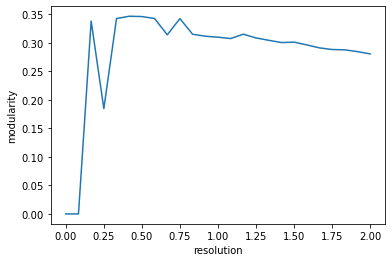

In [15]:
G = pickle.load(open('../local/directed_Multi_twitter_graph.pickle', 'rb'))
GM = G

# graph over resolution values
x = np.linspace(0,2,25)
y = [nx.community.modularity(GM,nx.community.louvain_communities(GM,resolution=resolution)) for resolution in x]

plt.plot(x,y)
plt.xlabel('resolution')
plt.ylabel('modularity')

print('max value: ', x[np.argmax(y)])
print('values ', list(zip(x,y)))

After having applied the Louvain algorithm, we sorted the communities, but not before confirming the increase in modularity. It turned out to match the graph which was good. 

In [16]:

Louvain_communities = nx.community.louvain_communities(GM,seed=420,resolution=0.5)
print(f"Modularity of our final community partitions: {nx.community.modularity(GM,Louvain_communities)}")
Louvain_communities = sorted(Louvain_communities,key=len)

Modularity of our final community partitions: 0.34861402925720664


It was now time to investigate these new communities to try and understand, why it was, that the modularity was so much higher compared to our simple party or party-chamber partitionings. We suspected that it might've had something to do with the Louvain algorithm taking into account the committees or caucus, which were users typically focused on a single policy issue. 

We suspected this to be the case, because when we removed all non-member nodes in our network and divided the network into party-chamber, we got a much higher modularity than when we had them included. So it was evident, that the committees and caucus had some sort of role to play in the difference of modularity between the party-chamber and the Louvain partitioning.

In [17]:
## Including all accounts
dem_House = [x for x,y in GM.nodes(data=True) if y['party']=="D" and y["chamber"] == "house"]
dem_Sen = [x for x,y in GM.nodes(data=True) if y['party']=="D" and y["chamber"] != "house"]
rep_House = [x for x,y in GM.nodes(data=True) if y['party']=="R" and y["chamber"] == "house"]
rep_Sen = [x for x,y in GM.nodes(data=True) if y['party']=="R" and y["chamber"] != "house"]
rest_members =  [x for x,y in GM.nodes(data=True) if y['party']!="R" and y["party"] != "D"]

party_chamber_partition = [dem_House,dem_Sen,rep_House,rep_Sen,rest_members]
party_chamber_partition = [set(x) for x in party_chamber_partition]

#Get modularity of this partition
print(nx.community.modularity(GM,party_chamber_partition))

0.25159022042418483


In [18]:
#Get a subgraph of only members and those of the two parties
GM_members = GM.subgraph([x for x,y in GM.nodes(data=True) if y['type']=="member"])

dem_House = [x for x,y in GM_members.nodes(data=True) if y['party']=="D" and y["chamber"] == "house"]
dem_Sen = [x for x,y in GM_members.nodes(data=True) if y['party']=="D" and y["chamber"] != "house"]
rep_House = [x for x,y in GM_members.nodes(data=True) if y['party']=="R" and y["chamber"] == "house"]
rep_Sen = [x for x,y in GM_members.nodes(data=True) if y['party']=="R" and y["chamber"] != "house"]
rest_members =  [x for x,y in GM_members.nodes(data=True) if y['party']!="R" and y["party"] != "D"]

party_chamber_partition = [dem_House,dem_Sen,rep_House,rep_Sen,rest_members]
party_chamber_partition = [set(x) for x in party_chamber_partition]

#Get modularity of this partition
partyChamber_onlyMembers_modularity =nx.community.modularity(GM_members,party_chamber_partition)
print(partyChamber_onlyMembers_modularity)

0.3328301440924899


Specifically we wanted to see, whether or not the algorithm centered some of the communities around committees or caucuses, as these represented policy issues rather than partisan organizations. In order to test this, we had to come up with some sort of centrality measure. We had a lot of different centrality measures to choose from, but we believed that in our context a simple indegree centrality measure made the most sense. Explained shortly, the indegree centrality of a node is just the number of edges pointing towards that node.

Choosing indegree as the centrality measure makes sense, as the number of mentions of a node clearly signifies its importance or how much it is being included in the discourses. Furthermore, our main purpose was to investigate whether or not centering some of the communities around committees or caucus increased the modularity. As the modularity is dependent on the indegree, this was another argument for using indegree centrality.

Finally, there are no physical restrictions to mentioning each other, which means, that users that which to establish a link between them and another Twitter user can simply mention each other. 

So unlike in for example a train network, where the central station occupies a central place in the network in terms of shortest paths to the other nodes, but may not have the highest amount of indegrees because of physical limitations. In our network, there would be no physical limitation between the committee, caucus, party or house member who was the main target of the public discourse, and those who participated in it, and we could therefore expect this main target to have a high indegree.

In [19]:
LV_seed = 420
LV_resolution = 0.5

def replace_na(graph,code_for_NaN = ''):
    #We turn NaNs into '' - this is only for Netwulf, as JSON cannot handle Nan values
    for node_key in graph.nodes:
        node = graph.nodes[node_key]
        for attribute in node.keys():
            if(type(node[attribute]) == float):

                #If !(x>=0 or x<=0) => x is not a float, x is a nan value
                if not(node[attribute] >= 0 or node[attribute] <= 0):
                    node[attribute] = code_for_NaN

def get_party_affiliation(Graph):
    normalizing_constant = len(Graph.nodes())
    affiliation_dict = defaultdict(int)
    replace_na(Graph,"None")

    for x,y in Graph.nodes(data=True):
        affiliation_dict[y["party"]] += 1

    for key in affiliation_dict.keys():
        affiliation_dict[key] = affiliation_dict[key]/normalizing_constant

    return affiliation_dict

def get_partisanShip(Graph):
    affiliation_dict = get_party_affiliation(Graph)
    return max([affiliation_dict["R"],affiliation_dict["D"]]) 

In the process of collecting information on the indegrees and types of various central nodes, we also opted to collect data on the communities within the network. This additional data allowed us to identify different classes of networks based on the community structure and the types of central nodes present within them.

Before we started on the actual analysis we wanted to do a quick visual comparison for the absolute indegree of the central node with the typical indegree of the community as a whole. We chose the median indegree as the statistic for the community to do this, as we knew the network as a whole followed a power law distribution with regards to the edges. As we saw in the first assignment, the average in a power law can easily be skewed by outliers, outliers that are characteristic of the power law distribution. 

The average in a heavy tailed distribution is also more likely not to converge to the true population mean due to the noise from outliers. Instead medians a more noise resilient as a single outlier in a 300 size community won't have any major impacts on this statistic.

Of course this characteristic wasn't bound to translate into the communities as well, but considering the size of our communities, we assumed them to mimic the network structure overall pretty well.

In [23]:
GM = pickle.load(open('../local/directed_Multi_twitter_graph.pickle', 'rb'))

#We give each node a size based on their indegree
for node in GM.nodes:
    GM.nodes[node]["size"] = GM.in_degree[node]

replace_na(GM)


sorted_louvain_communities = sorted(nx.community.louvain_communities(GM,resolution=LV_resolution, seed=LV_seed),key=len,reverse=True) # vi bruger resolution
sorted_louvain_communities = [list(community) for community in sorted_louvain_communities]


community_dicts = []

# We iterate over the communities, and find the top node in each community
for size_ranking,community in enumerate(sorted_louvain_communities[:10]):
    size = len(sorted_louvain_communities[size_ranking])
    top_node = {"name":None,"type":None,"indegree":0,"indegree_percentage":0}
    community_dict = {"top_node":top_node,"total_indegree":0,"size_ranking":size_ranking,"size":size,"top_node_type":None}
    total_indegree = []

    for member_name in community:

        #Get the indegree
        member_indegree = GM.in_degree[member_name]

        #If it is better than our top node, we add it
        if(member_indegree>top_node["indegree"]):
            top_node["name"] = member_name
            top_node["indegree"] = member_indegree
            top_node["type"] = GM.nodes[top_node["name"]]["type"]
        
        total_indegree += [member_indegree]

    community_dict["total_indegree"] = np.sum(total_indegree)
    top_node["indegree_percentage"] = top_node["indegree"]/community_dict["total_indegree"]
    community_dict["top_node"] = top_node
    community_dict["median_indegree"] = np.median(total_indegree)
    community_dict["top_node_type"] = top_node["type"]


    community_dicts += [community_dict]

for i, community_dict in enumerate(community_dicts):
    print("\nCommunity ",i)
    for key, value in community_dict.items():
        print(key, ' : ', value)


Community  0
top_node  :  {'name': 'House Republicans', 'type': 'party', 'indegree': 40813, 'indegree_percentage': 0.08808282327753654}
total_indegree  :  463348
size_ranking  :  0
size  :  327
top_node_type  :  party
median_indegree  :  794.0

Community  1
top_node  :  {'name': 'House Committee on the Judiciary', 'type': 'committee', 'indegree': 45833, 'indegree_percentage': 0.06093695571823256}
total_indegree  :  752138
size_ranking  :  1
size  :  321
top_node_type  :  committee
median_indegree  :  1394.0

Community  2
top_node  :  {'name': 'Senate Republicans', 'type': 'party', 'indegree': 15174, 'indegree_percentage': 0.09345495082128757}
total_indegree  :  162367
size_ranking  :  2
size  :  81
top_node_type  :  party
median_indegree  :  1492.0

Community  3
top_node  :  {'name': 'Chuck Schumer', 'type': 'member', 'indegree': 14868, 'indegree_percentage': 0.08868687591711105}
total_indegree  :  167646
size_ranking  :  3
size  :  57
top_node_type  :  member
median_indegree  :  2475

Once we had our data, we needed to structure it into a pandas dataframe and plot it using seaborn. Seaborn is a simple tool for making great graphs. As we had four types of measures for each community, we decided to make it 2D and let the size and colour of the datapoint be dependent on the size of the central node's community and the type of the central node respectively.

                                                name  partisanShip       type  \
0                                  House Republicans      0.914373      party   
1                   House Committee on the Judiciary      0.866044  committee   
2                                 Senate Republicans      0.790123      party   
3                                      Chuck Schumer      0.789474     member   
4  House Committee on Science, Space, and Technology      0.500000  committee   
5                 House Committee on Foreign Affairs      0.500000  committee   
6     House Committee on Education and the Workforce      0.333333  committee   
7                                          Mike Enzi      0.500000     member   

   size  size_ranking  Central Node Indegree%  
0   327             0                0.088083  
1   321             1                0.060937  
2    81             2                0.093455  
3    57             3                0.088687  
4     6             4         

[Text(0.5, 1.0, "Indegree and type of the central node in each community with the community's size and partisanship")]

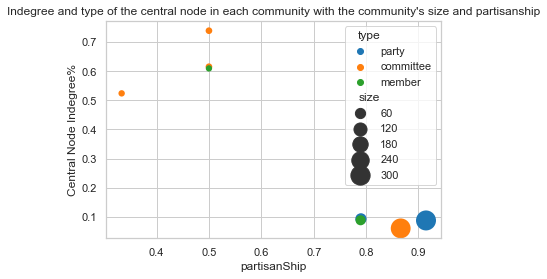

In [24]:
community_graph_dicts = []
for idx,louvain_community in enumerate(sorted_louvain_communities[:10]):
    chosen_community_dict = community_dicts[idx]
    size = chosen_community_dict["size"]
    top_type = chosen_community_dict["top_node_type"]
    partisanShip = get_partisanShip(GM.subgraph(louvain_community))
    name = chosen_community_dict["top_node"]["name"]
    proportion_degrees = chosen_community_dict["top_node"]["indegree_percentage"]
    size_ranking = chosen_community_dict["size_ranking"]

    community_graph_dicts += [{"name":name,"partisanShip":partisanShip,"type":top_type,"size":size,"size_ranking":size_ranking,"Central Node Indegree%":proportion_degrees}]

community_graph_DF = pd.DataFrame(community_graph_dicts)
print(community_graph_DF)

community_graph_DF = pd.DataFrame(community_graph_dicts)
sns.set_theme(style="whitegrid")
sns.scatterplot(data=community_graph_DF,x="partisanShip", y="Central Node Indegree%",
                hue="type", size="size",
                palette="tab10",sizes=(40, 400), linewidth=0).set(title='Indegree and type of the central node in each community with the community\'s size and partisanship' )

For the analysis of the communities and Louvain partition, we first defined a couple of data structures to work well with the different functions. Then, the modularity of the party partition was calculated.

In [25]:
dems = {x: 0 for x,y in GM.nodes(data=True) if y['party']=="D"}
reps = {x: 1 for x,y in GM.nodes(data=True) if y['party']=="R"}
indeps = {x: 2 for x,y in GM.nodes(data=True) if y['party']=="I"}
rest = {x: 3 for x,y in GM.nodes(data=True) if y['party']!="I" and y["party"] != "R" and y["party"] != "D"}
partyp = dict(dems, **reps)
partyp.update(indeps)
partyp.update(rest)

dems = {x: "dem" for x,y in GM.nodes(data=True) if y['party']=="D"}
reps = {x: "rep" for x,y in GM.nodes(data=True) if y['party']=="R"}
indeps = {x: "ind" for x,y in GM.nodes(data=True) if y['party']=="I"}
rest = {x: "oth" for x,y in GM.nodes(data=True) if y['party']!="I" and y["party"] != "R" and y["party"] != "D"}
partition_party = [list(dems),
                    list(reps),
                    list(indeps),
                    list(rest)]
nx.community.modularity(GM, partition_party)

0.20590990966243986

The party partitioning results in a modularity of 0.21, which is well below the pary-chamber modularity. Therefore, it seems that the communication more often is made within the chamber

Next, we will make a confusion matrix of the party partitioning versus the Louvain partitioning.

In [26]:
partition_GM_dict = dict()
for i, v in enumerate(sorted_louvain_communities):
    partition_GM_dict.update({x: i for x in sorted_louvain_communities[i]})

In [27]:
A = len(np.unique([x for x in partition_GM_dict.values()]))
community_header = np.unique([x for x in partyp.values()])

# community_indices = [i for i, j in enumerate(partition.values()) if j == community]
D = np.zeros((A, len(community_header)))
for i in range(A):
    lkv = [k for (k, v) in zip(partition_GM_dict.keys(), partition_GM_dict.values()) if v == i]
    for j in range (len(community_header)):
        ckv = [k for (k, v) in zip(partyp.keys(), partyp.values()) if v == j]
        D[i, j] = len([x for x in lkv if x in ckv])

print(D.T)

[[ 14. 278.   7.  45.   2.   2.   1.   0.]
 [299.  24.  64.   5.   3.   3.   1.   1.]
 [  1.   1.   1.   1.   0.   0.   0.   0.]
 [ 13.  18.   9.   6.   1.   1.   1.   1.]]


Below, a graph is made for the confusion matrix, with the proportion of the entire party in each community displayed in the cell text.

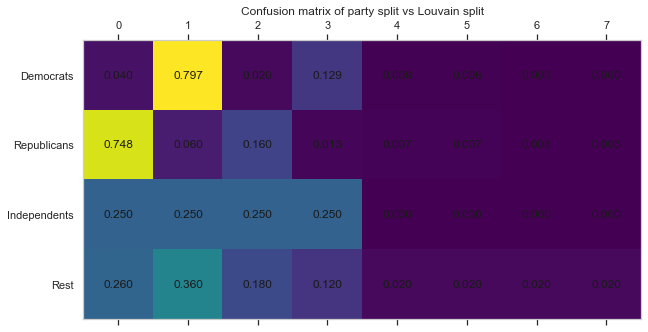

In [31]:
A = len(np.unique([x for x in partition_GM_dict.values()]))
community_header = np.unique([x for x in partyp.values()])

# community_indices = [i for i, j in enumerate(partition.values()) if j == community]
D = np.zeros((A, len(community_header)))
for i in range(A):
    lkv = [k for (k, v) in zip(partition_GM_dict.keys(), partition_GM_dict.values()) if v == i]
    for j in range (len(community_header)):
        ckv = [k for (k, v) in zip(partyp.keys(), partyp.values()) if v == j]
        D[i, j] = len([x for x in lkv if x in ckv])
    
for i in range(A):
    for j in range(len(community_header)):
        D[i, j] = D[i, j] / len([k for (k, v) in zip(partyp.keys(), partyp.values()) if v == j])
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(D.T, cmap=plt.cm.viridis)
# set the y-axis tick positions
ax.set_yticks(np.arange(4))
# set the y-axis tick labels
ax.set_yticklabels(["Democrats", "Republicans", "Independents", "Rest"])
ax.grid(False)
plt.title('Confusion matrix of party split vs Louvain split')
# Loop through each cell in the confusion matrix and add the cell value as text label
for i in range(len(community_header)):
    for j in range(A):
        text = ax.text(j, i, f"{D.T[i, j]:.3f}",
                       ha="center", va="center", color="k")
plt.show()

In the first two communities found by the algorithm, there is a clear division between republicans and democrats, with about 75% of the republicans being in the first community, and about 80% of the democrats being in the second community. In the third and fourth communities, the proportion of republicans to democrats vice versa is also low. 

Next, we do some summary statistics on the Louvain partitioning and investigate the sizes of the communities.

In [32]:
GMr = GM.copy()
nx.relabel_nodes(GMr, dict(zip(GMr, range(GMr.number_of_nodes()))))
GMrbp = sorted_louvain_communities.copy()
GMrbp_dict = dict()
for i, v in enumerate(GMrbp):
    GMrbp_dict.update({x: i for x in GMrbp[i]})

8 unique communities are found
{0: 327, 1: 321, 2: 81, 3: 57, 4: 6, 5: 6, 6: 3, 7: 2}
Modularity: 0.34861402925720664
Median: 31.5
Max: 327


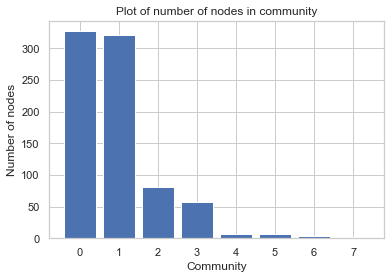

In [33]:
## Create a histogram of number of accounts in each Louvain community
com = np.unique(list(GMrbp_dict.values()))
ncom = len(com)
nincom = {x: len([k for (k, v) in zip(GMrbp_dict.keys(), GMrbp_dict.values()) if v == x]) for x in com}

print(str(ncom) + " unique communities are found")
print(nincom)
print("Modularity: " + str(nx.community.modularity(GMr, sorted_louvain_communities)))
print("Median: " + str(np.median([x for x in nincom.values()])))
print("Max: " + str(max([x for x in nincom.values()])))

plt.bar([y for y in nincom.keys()], [x for x in nincom.values()])
plt.xlabel("Community")
plt.ylabel("Number of nodes")
plt.title("Plot of number of nodes in community")
plt.show()

We see that the first four communities contain almost all the twitter accounts, with the first two having the most. We are curious about what this partitioning encodes, so we want to visualize the partitionings in netwulf.

Creating the graph of the Louvain partition, legends added in Adobe Illustrator afterwards:

In [ ]:
def convert_to_digraph(Mgraph):
    '''
        converts multigraph to digraph, for visualization in netwulf
    '''
    DiG = nx.DiGraph()
    edge_dict = defaultdict(lambda: {'year': [], 'ID': [],'weight':0})

    for u,v,data in Mgraph.edges(data=True):
        edge_data = edge_dict[(u,v)]

        edge_data['year'].append(data['year'])
        edge_data['ID'].append(data['ID'])

        # update weights
        edge_data['weight'] = len(edge_data['year'])

    # add edge data
    for key, value in edge_dict.items():
        DiG.add_edge(*key, **value) # DiGraph with 803 nodes and 142530 edges

    nx.set_node_attributes(DiG,Mgraph.nodes)


    return DiG

GML = convert_to_digraph(GM.copy()) # converts to directional graph for easy visualization in netwulf

## Colouring the nodes after community
for i, lvcom in enumerate(sorted_louvain_communities):
    if i == 0:
        for node in lvcom:
            GML.nodes[node]["color"] = "#f50202" ## Republican House majority
    elif i == 1:
        for node in lvcom:
            GML.nodes[node]["color"] = "#0202f5" ## Democratic House majority
    elif i == 2:
        for node in lvcom:
            GML.nodes[node]["color"] = "#fa6161" ## Republican Senate majority
    elif i == 3:
        for node in lvcom:
            GML.nodes[node]["color"] = "#6161ff" ## Democratic Senate majority
    elif i >= 4:
        for node in lvcom:
            GML.nodes[node]["color"] = "#fffa61" ## Others
GMLnw = nw.get_filtered_network(GML,edge_weight_key='weight')

Configuration for the netwulf visualization:

In [35]:
config = {
    # Input/output
    "zoom": 0.95,
    "node_charge": -47.55843554732701,
    "node_gravity": 0,
    "link_distance": 50,
    "link_distance_variation": 1,
    "node_collision": True,
    "wiggle_nodes": False,
    "freeze_nodes": False,
    "node_fill_color": "#79aaa0",
    "node_stroke_color": "#000000",
    "node_label_color": "#ff00e0",
    "node_size": 13.631103911131682,
    "node_stroke_width": 0.8,
    "node_size_variation": 0.32909048831289056,
    "display_node_labels": False,
    "scale_node_size_by_strength": True,
    "link_color": "#000000",
    "link_width": 5.076581809766257,
    "link_alpha": 0.33927331636195324,
    "link_width_variation": 0.8178662346679009,
    "display_singleton_nodes": True,
    "min_link_weight_percentile": 0,
    "max_link_weight_percentile": 1
}

In [36]:
#nw.visualize(GMLnw, config=config) 

![](./images/nwlvai.png)

Creating the graph of the party partition, legends added in Adobe Illustrator afterwards:

In [ ]:
GMo = GM.copy()
for i, party in enumerate(partition_party):
    if i == 0:
        for node in party:
            GMo.nodes[node]["color"] = "#0202f5" ## Republican
    elif i == 1:
        for node in party:
            GMo.nodes[node]["color"] = "#f50202" ## Democrat
    elif i == 2:
        for node in party:
            GMo.nodes[node]["color"] = "#fffa61" ## Independent
    elif i == 3:
        for node in party:
            GMo.nodes[node]["color"] = "#6afc60" ## Other

GMnw = nw.get_filtered_network(GMo,edge_weight_key='weight')

In [37]:
#nw.visualize(GMnw, config=config) ## Can't run in Jupyter notebook

![](images/nwpartyai.png)

Interestingly, it seems that the Louvain algorithm captures the party and chamber division, which we had suspected due to the party-chamber partitioning having a higher modularity.

## Data processing

In the data processing stage, we used the following regex formulas:

In [40]:
RT_pattern = "RT @[a-zA-Z0-9]*" #Pattern for retweets -> it looks for "RT @some_user_name"
mentions_re = "@[a-zA-Z0-9]*" #Pattern for finding mentions -> it looks for "@some_user_name"
hashtags_re = "#[a-zA-Z0-9]*" #Pattern for finding hashtags -> it looks for "#some_hastag"

We used them in the following functions, which we then further used to extract the mentions and hashtags in the different tweet texts.

In [41]:
RT_pattern = "RT @[a-zA-Z0-9]*"

def searchText(formula,twitter_message):
    try:
        matches = re.findall(formula,twitter_message)
        matches[0]
        return matches
    except:
        return None

#Takes a tweet and returns a list of mentions that are in our accounts_dataFrame and their corresponding users' names
def get_Handles_Names(tweet):
    mentions_re = "@[a-zA-Z0-9]*"
    mentions_excl_RT_re = "(?<!RT )@[a-zA-Z0-9]*" #Will exclude all mentions that follow "RT"
    mentions = searchText(mentions_re,tweet)
    screen_names = []
    names_result = []

    #If there is a mention
    if(mentions != None):
        mentions = [handle[1:] for handle in mentions] #Remove @

        #Add to our dict, if the mentions exist in our dataFrame
        for idx,handle in enumerate(mentions):
            names = accounts_dataFrame[accounts_dataFrame['screen_name'] == handle]['name']

            #If the handle exists in our filtered accounts_dataFrame
            if(len(names)>0):
                screen_names += [handle]
                names_result += list(names)
    if(len(names_result)>0):
        return screen_names,names_result
    else:
        return None,None

def get_tweeter_screen_name(tweet):
    return tweet["screen_name"]


## Tools used for Mixing Patterns and Assortativity

We want to start by investigating the network structure. Specifically, we want to investigate the mixing patterns based on parties. As a starting point, we compute the fraction of out edges that connects to users with the same party affiliation. Our null hypothesis is that mentions in tweets are not associated with parties, and we want to investigate this hypothesis with a 95% significance level. We then shuffle the members party affiliation 100 times and plot the distribution as a histogram together with the actual fraction from the data. The results are shown in the figure below.

In [42]:
# filter based on dem and rep
selected_nodes = [n for n,v in G.nodes(data=True) if v['party'] == 'D' or v['party'] == 'R' or v['party'] == 'I' ]  
G_filtered = G.subgraph(selected_nodes)


0.0
Reject the null hypothesis with p value:  0.0


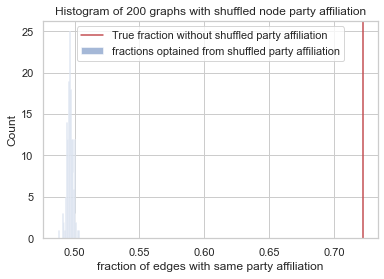

In [59]:
# gets the top field of each node
node_fiels_dict = nx.get_node_attributes(G_filtered,'party')


# goes over all nodes and its neighbor's calculates the fractions of neighbors in the same field
def neighbor_same_field_frac(G_filtered, node_fiels_dict):
    node_adj_same_field_frac_list = []

    # loops over all nodes
    for node_id in G_filtered.nodes:
        # gets their top field
        node_field = node_fiels_dict.get(node_id)
         
        # gets neighbors top field
        neighbor_fields = [node_fiels_dict.get(key) for key in G_filtered.neighbors(node_id)]
        
        # Creates list of true and false if they are in same field
        same_field_list = [1 if node_field == neighbor_field else 0 for neighbor_field in neighbor_fields]

        # adds fraction if node has edges
        if len(same_field_list) != 0:
            node_adj_same_field_frac_list.append(sum(same_field_list)/len(same_field_list))
        
    
    # returns mean over all nodes
    return np.mean(node_adj_same_field_frac_list)

node_adj_same_field_frac = neighbor_same_field_frac(G_filtered, node_fiels_dict)
print(f"node_adj_same_field_frac_list: {node_adj_same_field_frac}")

def shuffle_node_fiels_dict(node_fiels_dict):
    """ Function that shuffles top fields in a dictionary
    """
    # gets all top fields
    top_fields = list(node_fiels_dict.values())

    # shuffles top_fields
    shuffled_top_field = random.sample(top_fields, len(node_fiels_dict))

    # create new dict
    node_fiels_dict = dict(zip(list(node_fiels_dict.keys()), shuffled_top_field))

    return node_fiels_dict

# number of samples
n = 200

# we shuffle the top_field and calculate the fraction 200 times
neighbor_same_field_frac_shuffled_list = []
for i in range(n):
    node_fiels_dict = shuffle_node_fiels_dict(node_fiels_dict)
    neighbor_same_field_frac_shuffled_list.append(neighbor_same_field_frac(G_filtered, node_fiels_dict))

# Creates the histogram plot
fig, ax = plt.subplots()
ax.hist(neighbor_same_field_frac_shuffled_list, label='fractions optained from shuffled party affiliation', bins=30,color='b',alpha=.5)

ax.axvline(x=node_adj_same_field_frac,color='r',linestyle='-', label='True fraction without shuffled party affiliation')
ax.set_title('Histogram of 200 graphs with shuffled node party affiliation')
ax.legend()
ax.set_xlabel('fraction of edges with same party affiliation')
ax.set_ylabel('Count')

# We then perform a permutation test using the data genereated in the above cell
t_obs = node_adj_same_field_frac
tq = np.mean(neighbor_same_field_frac_shuffled_list > node_adj_same_field_frac)

# calculate p value
p_value = tq
print(p_value)

# Compare the p-value to the significance level (e.g., 0.05)
if p_value < 0.05:
    print("Reject the null hypothesis with p value: ", p_value)
else:
    print("Fail to reject the null hypothesis with p value: ", p_value)

By performing a permutation test, we get a p-value that is far below 0.05, and thus we discard the null hypothesis with a 95% significance level. This means that we can conclude that the chance that a tweet mentions a user with the same party affiliation is statistically significantly higher than it would be by chance. This supports the belief that members of the U.S congress are more likely to tweet each other internally in each party.

To further investigate this, we compute the assortativity coefficient with respect to party for Republicans, Democrats, and Independents. The edge count is shown in the confusion matrix below.

assortativity coefficient with respect to author's field:  0.6482423124188517


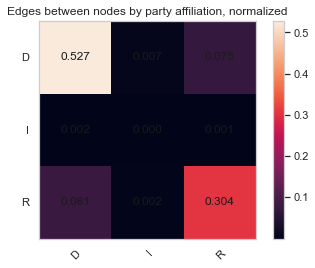

In [61]:
# extracts all unique 'top_field' values from the network G and stores them in a list called 'uniqe_top_fields
uniqe_top_fields = list(np.unique(list(node_fiels_dict.values())))
node_fiels_dict = nx.get_node_attributes(G_filtered,'party')

# creates a dictionary that maps each 'top_field' value to an index in the adjacency matrix 'e'.
uniqe_top_fields_mapping = {uniqe_top_fields[i]: i for i in range(len(uniqe_top_fields)) }
e = np.zeros((len(uniqe_top_fields),len(uniqe_top_fields)))

# Calcultes the matrix e from equation 2 in the recommended paper.
for node1, node2,weight in G_filtered.edges: # 
    node1_field = node_fiels_dict.get(node1)
    node1_field_index = uniqe_top_fields_mapping.get(node1_field)
    node2_field = node_fiels_dict.get(node2)
    node2_field_index = uniqe_top_fields_mapping.get(node2_field)

    # adds 1 to the total number of edges between these two fields
    e[node1_field_index, node2_field_index] += 1
    #e[node2_field_index, node1_field_index] += 1

e /= (len(G_filtered.edges))

# computes the assortativity coefficient
ass_coef = (np.trace(e) - np.sum(np.matmul(e,e))) / (1-np.sum(np.matmul(e,e)))
print("assortativity coefficient with respect to author's field: ", ass_coef)

# creates a plot to show the matrix e
fig, ax = plt.subplots()
im = ax.imshow(e)

# Show all ticks and label them with the respective list entries
ax.set_yticks(np.arange(len(uniqe_top_fields)))
ax.set_xticks(np.arange(len(uniqe_top_fields)))
ax.set_xticklabels(uniqe_top_fields)
ax.set_yticklabels(uniqe_top_fields)
plt.title('Edges between nodes by party affiliation, normalized')
ax.figure.colorbar(im, ax=ax)
ax.grid(False)

# Loop through each cell in the confusion matrix and add the cell value as text label
for i in range(len(uniqe_top_fields)):
    for j in range(len(uniqe_top_fields)):
        text = ax.text(j, i, f"{e[i, j]:.3f}",
                       ha="center", va="center", color="k")

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


plt.show()

This results in an assortativity coefficient of 0.64. This high party affiliation assortativity coefficient implies social polarization based on party. With intra-party communication of democrats and republicans being 50% and 30% of tweets respectively and inter party communication being 7.5% and 8.1% respectively. When doing this analysis it is important to mention that not all mentions/edges are communication between user, but some are simply members tagging or promoting other members campaigns. These have been included but arguments can be made for excluding them as they might not represent active conversation.

## Tools used in the tweet analysis section

The mean tools used in the text analysis section is TF-IDF.  TF-IDF works by calculating the term frequency of each token in each community, and then weighting the term frequency by the inverse community frequency. As it is weighted by the community frequency it is a good way to get frequent words that are uniqe to each community. 
We have used a special regex to clean and tokenise each tweet ```https?://\S+|@\w+|&\w+|#\w+|[^\w\s]|[^a-zA-Z\s]+```. It is a set of 'or' criterias that each remove some unwanted item from the text. The first part removes all links, the next 3 parts remove the "@", "&","#" symbols and the following text before a whitespace. The last part '[^\w\s]|[^a-zA-Z\s]+' removes all none word characters.

The full code is shown below

In [71]:
# Loads tweets
textdf = pd.read_csv('../local/google_drive_benjamin/textDF')

# drop all columns except for the text and tweet_id column
textdf = textdf.drop(['Unnamed: 0','user_name','screen_name'],axis=1)

textdf_dict = dict(zip(textdf.tweet_ID, textdf.text))

# Loads graph
G = pickle.load(open('../local/directed_Multi_twitter_graph.pickle', 'rb'))

def convert_to_digraph(Mgraph):
    """
        Converts graph to directed graph where weights are the number of edges between two nodes
    """
    DiG = nx.DiGraph()
    edge_dict = defaultdict(lambda: {'year': [], 'ID': [],'weight':0})

    for u,v,data in Mgraph.edges(data=True):
        edge_data = edge_dict[(u,v)]

        edge_data['year'].append(data['year'])
        edge_data['ID'].append(data['ID'])

        # update weights
        edge_data['weight'] = len(edge_data['year'])

    # add edge data
    for key, value in edge_dict.items():
        DiG.add_edge(*key, **value) # DiGraph with 803 nodes and 142530 edges

    nx.set_node_attributes(DiG,Mgraph.nodes)

    return DiG

G = convert_to_digraph(G)

In [72]:
def tokenize_tweet(raw_tweet: str):
    # Remove URLs, mentions, hashtags, punctuation, and any any non-alphabetic characters
    raw_tweet = re.sub(r'https?://\S+|@\w+|&\w+|#\w+|[^\w\s]|[^a-zA-Z\s]+', '', raw_tweet.lower())

    # tokenize -> converts each word to a list element
    tokens = nltk.word_tokenize(raw_tweet, language='english')

    # loads in predifined english stop words
    stop_words = set(stopwords.words('english'))
    # ads domain Specific Stop words specific for twitter, this includes rt for retweets and qt for quoted tweets
    stop_words.update(['rt','qt','amp','lr','cm','im', 'today', 'us','must','would','thank','new','bcbra','cm','rsc','rnh'])

    tokens = [token for token in tokens if token not in stop_words]
    
    return tokens

In [82]:
with open('../local/sorted_louvain_communities.pickle', 'rb') as handle:
    partition_GM = pickle.load(handle)

G_partitions = partition_GM[:6]

G_partitions_tokens = []
 
for i, G_partition in enumerate(G_partitions):
    tweets_ids_in_partition = []
    tweets_tokenized_in_partition= []

    for node in G_partition:
        for mention_node in G[node].keys():
            edge_data = G[node][mention_node]
            for tweet_id in edge_data['ID']:
                tweets_ids_in_partition.append(tweet_id)

    for tweet_id in tqdm(tweets_ids_in_partition, desc=f'Tokenizing tweets {i+1} of {len(G_partitions)}'):
        tweet_text = textdf_dict[tweet_id]
        tokenized_tweet = tokenize_tweet(tweet_text)
        tweets_tokenized_in_partition += tokenized_tweet
    
    G_partitions_tokens.append(tweets_tokenized_in_partition)

Tokenizing tweets 6 of 6: 100%|██████████| 16625/16625 [00:04<00:00, 3397.66it/s]


Calculates TF for each community

In [86]:
from copy import deepcopy
tf_dict = defaultdict(lambda: defaultdict(lambda: 0)) # term documents

for i, partition_tokens in enumerate(G_partitions_tokens):
    # calculates TF for community
    for token in partition_tokens:
        tf_dict[token][i] += 1 / len(partition_tokens)

top5_tokens = []
for partition_index in range(len(G_partitions_tokens)):
   tf_dict_copy = deepcopy(tf_dict) # makes deepcopy to not change default dict structure
   sorted_tokens = sorted(tf_dict_copy, key=lambda x: tf_dict_copy[x][partition_index], reverse=True)#

   top5_tokens.append(sorted_tokens[:10])

print(f'Top 10 tokens for partitions')
# print matrix as table using markdown
print('| Partition | Top 10 Tokens |')
print('| --- | --- |')
for i, top5 in enumerate(top5_tokens):
    print(f'| {i} | {", ".join(top5)} |')
    

Top 10 tokens for partitions
| Partition | Top 10 Tokens |
| --- | --- |
| 0 | house, american, democrats, act, bill, americans, biden, congress, people, border |
| 1 | act, house, congress, bill, people, proud, health, work, american, need |
| 2 | senate, bill, act, american, bipartisan, support, help, americans, work, democrats |
| 3 | senate, act, bill, health, help, care, need, bipartisan, people, americans |
| 4 | act, research, science, bill, read, american, hearing, energy, house, committee |
| 5 | people, house, act, chairman, support, statement, president, security, american, foreign |


Calculates IDF for each community

In [87]:
# IDF for each document
idf_dict = {}
num_docs = len(G_partitions_tokens)
for token in tf_dict:
    idf_dict[token] = np.log(num_docs / (len(tf_dict[token]))) # all tf_dict tokens apears so we do not need to add 1

Calculates tf-idf

In [88]:
# Calculate the TF-IDF weight for each term in each document
tfidf_dict = defaultdict(lambda: defaultdict(lambda: 0)) 
for token in tf_dict:
    for community_index in tf_dict[token]:
        tfidf_dict[community_index][token] = tf_dict[token][community_index] * idf_dict[token]

In [89]:
# Prints top 10 TF-IDF for each community 
top_10_TFIDF = []
for community_index in tfidf_dict:
    top_10_TFIDF.append(sorted(tfidf_dict[community_index], key=lambda x: tfidf_dict[community_index][x],reverse=True)[:10])
    #print("Top 10 TF-IDF words for community: ",community_index, )

print(f'Top 10 TF-IDF for partitions')
# print matrix as table using markdown
print('| Partition | Top 10 TF-IDF |')
print('| --- | --- |')
for i, top10 in enumerate(top_10_TFIDF):
    print(f'| {i} | {", ".join(top10)} |')

Top 10 TF-IDF for partitions
| Partition | Top 10 TF-IDF |
| --- | --- |
| 0 | joe, schiff, mandate, adam, ec, farm, sham, defund, censure, infanticide |
| 1 | student, immigrant, progressive, citizenship, hall, weapons, sisters, para, los, cpc |
| 2 | rubio, joe, hatch, tennessee, georgia, farm, idaho, hawley, iowans, iowas |
| 3 | georgia, nevadans, nevada, student, stock, jackson, nh, nominees, doug, hampshire |
| 4 | oklahomas, telescope, oklahoma, rubin, researchers, quantum, icorps, possibleeven, necessaryto, telescopes |
| 5 | ametamct, ambassador, diplomacy, terrorist, weapons, regimes, syria, iranian, africa, gratitudeand |


Creates wordcloud based on TF-IDF (to get better words than simply the most frequent)

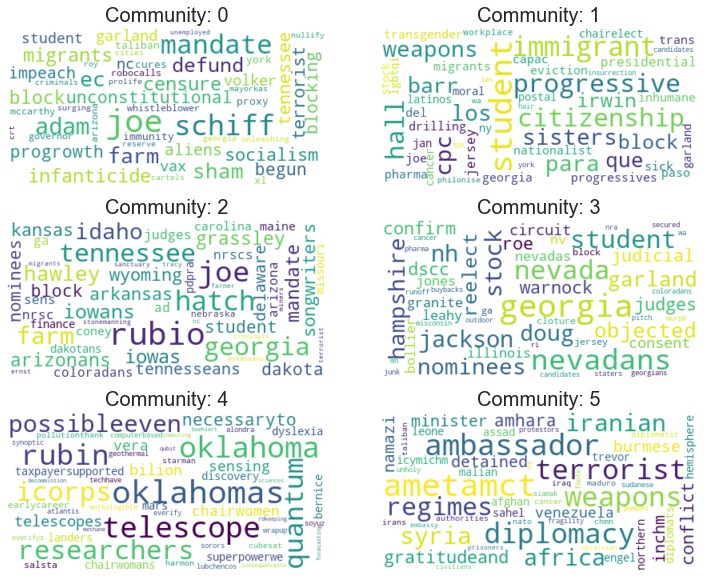

In [92]:
from wordcloud import WordCloud
# Generate a word cloud image
fig, axs = plt.subplots(3,2, figsize=(20,10))
#fig.subplots_adjust(hspace=-.2)
fig.subplots_adjust(wspace=-0.5)

for i, community_index in enumerate(tfidf_dict):
    #wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(['sadf','sadf'])
    wordcloud = WordCloud(max_font_size=40, max_words=50, background_color="white").generate_from_frequencies(tfidf_dict[community_index])

    axs[i // 2, i % 2].imshow(wordcloud, interpolation="bilinear")
    axs[i // 2, i% 2].axis("off")
    axs[i // 2, i% 2].set_title(f'Community: {community_index}', fontsize=20)

    if i == 6:
        break

plt.show()

Finally the biggest nodes in each comminty

In [93]:
G_partitions

top_3_nodes_per_community = []

for i, G_partition in enumerate(G_partitions):
    top_3_nodes_per_community.append(sorted(G_partition, key=lambda x: G.degree(x,weight='weight'), reverse=True)[:3])

print(f'Top 3 accounts for partitions')
# print matrix as table using markdown
print('| Partition | Top 3 accounts |')
print('| --- | --- |')
for i, top10 in enumerate(top_3_nodes_per_community):
    print(f'| {i} | {", ".join(top10)} |')

Top 3 accounts for partitions
| Partition | Top 3 accounts |
| --- | --- |
| 0 | House Republicans, House Committee on Energy and Commerce, House Committee on Ways and Means |
| 1 | House Democrats, House Committee on the Judiciary, Hispanic Caucus |
| 2 | Senate Republicans, John Cornyn, Ted Cruz |
| 3 | Senate Democrats, Chuck Schumer, Dick Durbin |
| 4 | House Committee on Science, Space, and Technology, Eddie Bernice Johnson, Frank Lucas |
| 5 | House Committee on Foreign Affairs, Michael McCaul, Gregory Meeks |


To read the full analysis of these tables go to https://christian-kento-rasmussen.github.io/US-Congress-Twitter-Behavior/congressional-communities/

## Temporal analysis

As a final step we wanted to see how these measures changed over time. To do this we have plottet the assortativity and modularity for each year

(0.0, 0.40593853261866025)

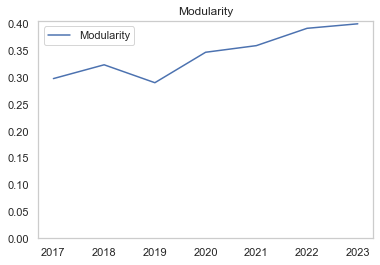

In [97]:
modularity_list = []

for year in ['2017','2018','2019','2020','2021','2022','2023']:
    G = pickle.load(open(f'../local/directed_multi_twitter_graph_fixed{year}.pickle', 'rb'))
    subgraph_nodes = list(G.nodes())
    
    subgraph_partision = [list(set(group_list).intersection(subgraph_nodes)) for group_list in partition_GM]
    
    modularity_list.append(nx.community.modularity(G,subgraph_partision))


plt.plot([2017,2018,2019,2020,2021,2022,2023], modularity_list, label='Modularity')
plt.legend()
plt.grid()
plt.title('Modularity')
plt.ylim(bottom=0)

From the above plot we can see that the assortativity coefficient is increasing over time. And the cross-party communication is decreasing. This shows that the party members are becoming more polarized as they on average talk with less people from the other party year-to-year.

When looking at the modularity of the Louvain communities found in the previous section, we can see that the modularity has increased from 2017 to 2023. This means that the communities are becoming more distinct and less overlapping. This is also a sign of polarization.

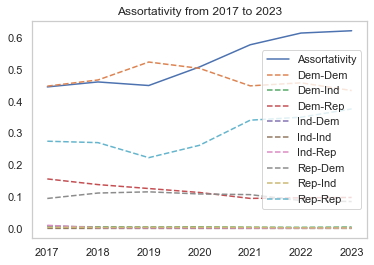

In [100]:
normalized_list = []
ass_coef_list = []


for year in ['2017','2018','2019','2020','2021','2022','2023']:
    G = pickle.load(open(f'../local/directed_multi_twitter_graph_fixed{year}.pickle', 'rb'))
    G = convert_to_digraph(G)

    selected_nodes = [n for n,v in G.nodes(data=True) if v['party'] == 'D' or v['party'] == 'R' or v['party'] == 'I' ]  
    G = G.subgraph(selected_nodes)

    # extracts all unique 'top_field' values from the network G and stores them in a list called 'uniqe_top_fields
    uniqe_top_fields = list(np.unique(list(node_fiels_dict.values())))
    node_fiels_dict = nx.get_node_attributes(G,'party')

    # creates a dictionary that maps each 'top_field' value to an index in the adjacency matrix 'e'.
    uniqe_top_fields_mapping = {uniqe_top_fields[i]: i for i in range(len(uniqe_top_fields)) }
    e = np.zeros((len(uniqe_top_fields),len(uniqe_top_fields)))

    # Calcultes the matrix e from equation 2 in the recommended paper.
    for node1, node2 in G.edges: #weight
        node1_field = node_fiels_dict.get(node1)
        node1_field_index = uniqe_top_fields_mapping.get(node1_field)
        node2_field = node_fiels_dict.get(node2)
        node2_field_index = uniqe_top_fields_mapping.get(node2_field)

        # adds 1 to the total number of edges between these two fields
        e[node1_field_index, node2_field_index] += 1
        #e[node2_field_index, node1_field_index] += 1

    e /= (len(G.edges))
    normalized_list.append(e)

    # computes the assortativity coefficient
    ass_coef = (np.trace(e) - np.sum(np.matmul(e,e))) / (1-np.sum(np.matmul(e,e)))
    ass_coef_list.append(ass_coef)

normalized_list = np.array(normalized_list)
normalized_list= normalized_list.reshape((7,9))
normalized_list = normalized_list.transpose(1,0)

plt.plot([2017,2018,2019,2020,2021,2022,2023], ass_coef_list, label="Assortativity")

for normalized,label in zip(normalized_list, ["Dem-Dem","Dem-Ind","Dem-Rep","Ind-Dem","Ind-Ind","Ind-Rep","Rep-Dem","Rep-Ind","Rep-Rep"]):
    plt.plot([2017,2018,2019,2020,2021,2022,2023],normalized, label=label,linestyle='dashed')

plt.title("Assortativity from 2017 to 2023")
plt.grid()
plt.legend(loc="right")
plt.show()

These measures shows a worrying trend in the US political landscape on social media. The communities are becoming more distinct, which indicates that parties are becoming more polarized. Assuming political discourse on twitter is consistent with the political discourse of congress in general, the US congress is undergoing a troublesome evolution that could hinder the US democratic process.

# Section 4: Discussion. Think critically about your creation

## Improvement in the Community detection

We made some assumptions in our community-section. One of these implicit assumptions was, that the single sample of the Louvain algorithm was representative of running the Louvain algorithm in general. If we had had more time, we could've investigated the communities with a more general perspective in mind. For example, we could've derived the distribution of the modularity gained from running the Louvain algorithm and from that attested whether or not our single sample was significantly different from the modularity of the population. In general though, for a graph of this size, it is highly unlikely that such a large increase in modularity is not statistically significant.

If we had had more time, we could've also gone a little more in-depth in our community partitions. We did very quickly cover what we thought underlined the increase in modularity when we did the Louvain algorithm and we had shown that our assumption, if not wrong, at least didn't manifest itself in the way we expected. 

But we could've done it more thoroughly and perhaps looked at sub-communities or other central nodes to figure out what role the non-partisan nodes played in increasing the modularity, if we had had more time. However, doing text analysis was also an acceptable substitution as it gave us some insight into what the communities might've been based on.

We could've also to a greater extent investigated how committees and caucuses tie into the political polarization. As we quickly showed, there are certain committees and caucuses that appear to clearly be within the control of a single political party. We could've looked at how the organizational users related to the political parties with the help of f.ex. path centrality. This could perhaps have helped us give a more nuanced conclusion about the polarization, but it was evidently not necessary.

We could've also confirmed whether or not the communities followed the edge distribution from the Network. This was a minor thing, but it would've been nice to do.

## Improvement in the Semantic Analysis of Edges

Another big assumption we made, was that nodes who communicate a lot with each other are necessarily less polarized and vise versa. While this is generally true as less communication equals more polarization, these are tweets, and tweets carry a great deal of semantic information which we did not derive. 

Even if you have a community with 0.5 partisanship and a high degree of clustering, it could still be polarized. If the average semantic value between members of the two parties is very negative, it is clearly not a case of de-polarization, but rather mudslinging and perhaps even more polarization than no contact. However, in our model this would've counted towards less polarization.

This didn't prove to be such a huge issue for our analysis however, as all of our biggest communities had a very high partisanship and were therefore polarized regardless.

## Improvement in the Text Analysis

In the text analysis section,there are a couple of TF-IDF words such as "possibleeven" and "necessaryto". These words looks to be created from errors in the text processing. We have found out that in many cases there was an emoji in between the two words which then was removed in the text processing resulting in these made up words.
In the future we can fix this by starting with replacing emoji's with whitespaces.
Likewise, some of the state names could have been excluded in the text analysis, but for at least one of the smaller communities, the mentioning of Oklahoma actually had a meaning besides campaigning or specific incidents. However, it could have been improved by simply making one analysis with and one without state names. 


## Demographics

Originally we wanted to also look at the connection between demographics and polarization, whether demographics affected which party the person was a member of, and if it affected how much they were willing to speak across political party. The tool we used for this was extremely inaccurate and gave us a completely wrong demographic for the congress, so we decided not to pursue any attempts at tieing in demographics into our investigation. 

# What went well?

Overall we are excited about the results. It was delightful to see that the visualizations of the Louvain partitioning using Netwulf revealed 4 almost perfect splits of democrats and republicans from the two different chambers.
Furthermore, it was amazing to see how the analysis of communities and the twitter text could reveal trends in the dataset that might be invisible to the naked eye, which could be used to formulate hypotheses about how the different congressmembers communicate on social media.

## Conclusion

In conclusion, we have found a clear indication of polarization in the time period that our data streches over. We conclude that the polarization has increased from 2017 to 2023 based the decrease in cross-party communication on twitter and the growing modularity score of the communities year-on-year. Assuming political discourse on twitter is consistent with the political discourse of congress in general, this would mean that the US congress is undergoing a troublesome evolution that could hinder the US democratic process.

This is also evident from the fact that the biggest communities identified by the Louvain algorithm have partisanship scores above 0.9, with the four largest having scores around or above 0.8. Additionally, we could visually see, that the Louvain algorithm partitioned our graph almost perfectly around political party and chamber, emphasizing the trend towards polarization.
